In [1]:
import sys
from pathlib import Path
#------------ Define the path to the folder containing your scripts
scripts_path = Path("/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/scripts").resolve()
#------------ Add this path to sys.path if it's not already included
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))
    
from train import*
from data_processing import*
from model import Model
from data_loader import*
from packages import*

In [5]:
# ---------------------------
# Configuration Parameters
# ---------------------------
basin = '01022500'            # 8-digit basin ID from the CAMELS dataset (modifiable)
hidden_size = 10              # Number of LSTM cells in the model
dropout_rate = 0.0            # Dropout rate for the final fully connected layer (0.0 to 1.0)
learning_rate = 1e-3          # Learning rate for the optimizer
sequence_length = 365         # Length (in days) of the meteorological record for each sample

# ---------------------------
# Dataset Setup
# ---------------------------
# Define date ranges for each dataset partition

# Training Data: from October 1, 1980 to September 30, 1995.
train_start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
train_end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[train_start_date, train_end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# For evaluation datasets, use the training means and standard deviations for normalization.
means = ds_train.get_means()
stds = ds_train.get_stds()

# Validation Data: from October 1, 1995 to September 30, 2000.
val_start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
val_end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[val_start_date, val_end_date],
                   means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test Data: from October 1, 2000 to September 30, 2010.
test_start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
test_end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[test_start_date, test_end_date],
                    means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

# ---------------------------
# Model, Optimizer, and Loss Setup
# ---------------------------
# Initialize the LSTM model with the specified parameters and move it to the appropriate device.
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)

# Setup the optimizer (Adam) for training the model.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error.
loss_func = nn.MSELoss()

# ---------------------------
# Summary and Debug Information
# ---------------------------
print("Configuration:")
print(f" Basin ID: {basin}")
print(f" Sequence length: {sequence_length}")
print(f" Hidden size: {hidden_size}")
print(f" Dropout rate: {dropout_rate}")
print(f" Learning rate: {learning_rate}")
print(f" Training period: {train_start_date.date()} to {train_end_date.date()}")
print(f" Validation period: {val_start_date.date()} to {val_end_date.date()}")
print(f" Test period: {test_start_date.date()} to {test_end_date.date()}")
print("\nModel summary:")
print(model)


Configuration:
 Basin ID: 01022500
 Sequence length: 365
 Hidden size: 10
 Dropout rate: 0.0
 Learning rate: 0.001
 Training period: 1980-10-01 to 1995-09-30
 Validation period: 1995-10-01 to 2000-09-30
 Test period: 2000-10-01 to 2010-09-30

Model summary:
Model(
  (lstm): LSTM(5, 10, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [6]:
n_epochs = 20 # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Validation NSE: {nse:.2f}")

Epoch 1: 100%|████████████████████| 20/20 [00:01<00:00, 16.37it/s, Loss: 0.6622]


Validation NSE: 0.10


Epoch 2: 100%|████████████████████| 20/20 [00:00<00:00, 20.58it/s, Loss: 1.0543]


Validation NSE: 0.15


Epoch 3: 100%|████████████████████| 20/20 [00:00<00:00, 20.69it/s, Loss: 0.7941]


Validation NSE: 0.20


Epoch 4: 100%|████████████████████| 20/20 [00:00<00:00, 20.82it/s, Loss: 1.2346]


Validation NSE: 0.24


Epoch 5: 100%|████████████████████| 20/20 [00:01<00:00, 19.50it/s, Loss: 1.1684]


Validation NSE: 0.30


Epoch 6: 100%|████████████████████| 20/20 [00:00<00:00, 20.76it/s, Loss: 1.1218]


Validation NSE: 0.38


Epoch 7: 100%|████████████████████| 20/20 [00:01<00:00, 19.46it/s, Loss: 0.5277]


Validation NSE: 0.47


Epoch 8: 100%|████████████████████| 20/20 [00:01<00:00, 17.57it/s, Loss: 0.4709]


Validation NSE: 0.53


Epoch 9: 100%|████████████████████| 20/20 [00:00<00:00, 20.38it/s, Loss: 0.4239]


Validation NSE: 0.57


Epoch 10: 100%|███████████████████| 20/20 [00:00<00:00, 21.08it/s, Loss: 0.5257]


Validation NSE: 0.60


Epoch 11: 100%|███████████████████| 20/20 [00:00<00:00, 20.84it/s, Loss: 0.2929]


Validation NSE: 0.62


Epoch 12: 100%|███████████████████| 20/20 [00:00<00:00, 20.86it/s, Loss: 0.3013]


Validation NSE: 0.64


Epoch 13: 100%|███████████████████| 20/20 [00:00<00:00, 20.83it/s, Loss: 0.4490]


Validation NSE: 0.65


Epoch 14: 100%|███████████████████| 20/20 [00:01<00:00, 19.22it/s, Loss: 0.5694]


Validation NSE: 0.65


Epoch 15: 100%|███████████████████| 20/20 [00:01<00:00, 19.89it/s, Loss: 0.3405]


Validation NSE: 0.67


Epoch 16: 100%|███████████████████| 20/20 [00:01<00:00, 17.67it/s, Loss: 0.1942]


Validation NSE: 0.68


Epoch 17: 100%|███████████████████| 20/20 [00:00<00:00, 20.81it/s, Loss: 0.2467]


Validation NSE: 0.68


Epoch 18: 100%|███████████████████| 20/20 [00:00<00:00, 20.86it/s, Loss: 0.2675]


Validation NSE: 0.70


Epoch 19: 100%|███████████████████| 20/20 [00:00<00:00, 21.07it/s, Loss: 0.2346]


Validation NSE: 0.70


Epoch 20: 100%|███████████████████| 20/20 [00:01<00:00, 19.73it/s, Loss: 0.2262]


Validation NSE: 0.70


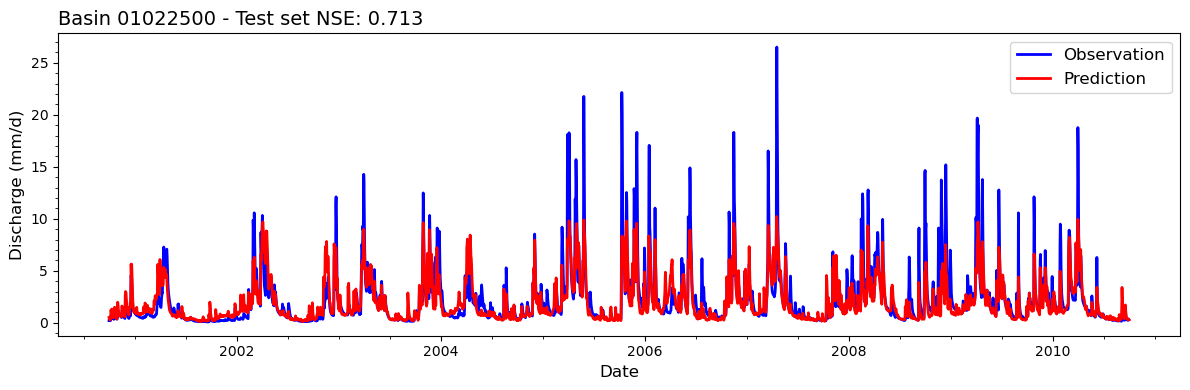

In [13]:
# Evaluate the model on the test set
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Create a date range for plotting based on the test set dates
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

# Generate a standard time series plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="Observation", lw=2, color="blue")
ax.plot(date_range, preds, label="Prediction", lw=2, color="red")
ax.set_title(f"Basin {basin} - Test set NSE: {nse:.3f}", fontsize=14, loc = "left")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Discharge (mm/d)", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='x')
ax.minorticks_on()
plt.tight_layout()
plt.show()